In [26]:

%reload_ext autoreload
%autoreload 2

# import local packages
import sys
sys.path.append('..')
from deepimpact import *

# import python packages
import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

def plot_analytical_case(result, outcome, title=None, figsize=(8, 10)):
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    GridSpec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)

    subfig1 = fig.add_subfigure(GridSpec[0, 0])
    subfig2 = fig.add_subfigure(GridSpec[1, 0])

    axs1 = subfig1.subplots(1, 3, sharey=True).flatten()
    axs2 = subfig2.subplots(1, 5).flatten()

    if title:
        fig.suptitle(title, fontsize=18)

    axs1[0].plot(result.dedz, result.altitude*1e-3)
    axs1[0].axhline(y = outcome["burst_altitude"]*1e-3, color = 'r', linestyle = '--')
    axs1[0].annotate(
        'burst_peak_dedz',
        xy=(outcome["burst_peak_dedz"], outcome["burst_altitude"]*1e-3),
        xytext=(0.6 * outcome["burst_peak_dedz"], outcome["burst_altitude"] * 1e-3 + 5),
        arrowprops=dict(facecolor='black', shrink=0.05)
    )
    axs1[0].annotate(
        "burst_altitude",
        (0., outcome["burst_altitude"] * 1e-3 + 1)
    )
    axs1[0].set_xlabel("Energy lost per unit height (kT/km)")
    axs1[0].set_ylabel("Altitude (km)")
    axs1[0].grid(True)

    axs1[1].plot(result.distance * 1e-3, result.altitude * 1e-3)
    axs1[1].set_xlabel("Distance (km)")
    axs1[1].grid(True)

    axs1[2].plot(result.time, result.altitude * 1e-3)
    axs1[2].set_xlabel("Time (s)")
    axs1[2].grid(True)

    # plot the second subfigure
    axs2[0].plot(result.time, result.velocity)
    axs2[0].set_xlabel("Time (s)")
    axs2[0].set_ylabel("Velocity (m/s)")
    axs2[0].grid(True)

    axs2[1].plot(result.time, result.mass)
    axs2[1].set_xlabel("Time (s)")
    axs2[1].set_ylabel("Mass (kg)")
    axs2[1].grid(True)

    axs2[2].plot(result.time, result.angle)
    axs2[2].set_xlabel("Time (s)")
    axs2[2].set_ylabel("Angle")
    axs2[2].grid(True)

    axs2[3].plot(result.time, result.distance)
    axs2[3].set_xlabel("Time (s)")
    axs2[3].set_ylabel("Distance (m)")
    axs2[3].grid(True)

    axs2[4].plot(result.time, result.radius)
    axs2[4].set_xlabel("Time (s)")
    axs2[4].set_ylabel("Radius (m)")
    axs2[4].grid(True)

class AtmosphericErrorAnalysis:
    def __init__(self):
        pass

    def simulate(self, y0, t, density, planet, radians=False):
        fractioned_phase = 0
        y0[3] = np.deg2rad(y0[3]) if not radians else y0[3]
        y = integrate.odeint(lambda t, y: planet.dy_dt(y, fractioned_phase, density), np.array(y0), t, tfirst=True)
        df = pd.DataFrame(y, columns=["distance", "velocity", "altitude", "angle", "mass", "radius"])
        df['angle'] = np.rad2deg(df['angle']) if not radians else df['angle']
        df["time"] = t
        return df

    def compute_error(self, dt, cratering_input, ode_method, planet):
        solution = planet.solve_atmospheric_entry(dt=dt, dt_ode=dt, **cratering_input, ode_method=ode_method)
        solution = planet.calculate_energy(solution)
        solution = solution[["distance", "velocity", "altitude", "angle", "mass", "radius", "time"]]

        x0 = 0.0
        density = cratering_input['density']
        vel0 = cratering_input['velocity']
        radius0 = cratering_input['radius']
        z0 = cratering_input['init_altitude']
        theta0 = cratering_input['angle']
        mass0 = (4.0 / 3.0) * np.pi * density * radius0**3
        y0 = [x0, vel0, z0, theta0, mass0, radius0]
        scipy_solution = self.simulate(y0, solution['time'], density, planet, cratering_input['radians'])
        
        solution.drop(columns=['time'], inplace=True)
        scipy_solution.drop(columns=['time'], inplace=True)

        # Assuming real_values is structured similarly to y
        error = np.sqrt(np.mean((scipy_solution - solution)**2, axis=0))
        error['dt'] = dt
        return error

    def error_analysis(self, dt_values, cratering_input, ode_methods, planet):
        errors_methods = {}
        for ode_method in ode_methods:
            errors = pd.DataFrame()
            for dt in dt_values:
                errors[dt] = self.compute_error(dt, cratering_input, ode_method, planet)
            errors_methods[ode_method] = errors.T
        return errors_methods

    def plot_analysis(self, errors_methods, title, figsize=(12, 8)):
        # Set up a 3x3 grid of subplots
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier indexing
        fig.suptitle(title, fontsize=18)
            
        # Iterate over the error methods and plot
        for i, (ode_method, errors) in enumerate(errors_methods.items()):
            # Iterate over the error components and plot
            for i, col in enumerate(errors.columns):
                if col != 'dt':
                    EPS = 1e-12
                    ax = axes[i]  # Get the current axis
                    ax.plot(errors['dt'], errors[col] + EPS, '*--', label=ode_method)
                    ax.set_title(f'Error in {col}')
                    ax.set_xlabel('dt')
                    ax.set_ylabel('Error')
                    ax.grid(True)
                    ax.set_yscale('log')  # Set y-axis to logarithmic scale
                    ax.set_xscale('log')  # Set x-axis to logarithmic scale
                    ax.legend()

        plt.tight_layout()
        plt.show()

def plot_meteor_paths(param_values, planet, planet_input, figsize=(18, 6)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes = axes.flatten()
    for i, (param_name, param_value) in enumerate(param_values.items()):
        for value in param_value:
            tmp_planet_input = planet_input.copy()
            tmp_planet_input[param_name] = value
            result = planet.calculate_energy(planet.solve_atmospheric_entry(**tmp_planet_input))
            axes[i].plot(result['distance'], result['altitude'])
        
        axes[i].legend(param_value, title = f'{param_name.title()}')
        axes[i].set_xlabel('Distance')
        axes[i].set_ylabel('Altitude')
        axes[i].set_title('Meteor Path with Varied Velocity')
        axes[i].grid(True)

    
    plt.tight_layout()
    plt.show()


## Input Parameters table for the solver:

| Parameter            | Description                                       |
|----------------------|---------------------------------------------------|
| atmos_func           | Function to compute atmospheric density at altitude, z |
| atmos_filename       | Name of the filename for tabular atmos_func option |
| Cd                   | Drag coefficient                                  |
| Ch                   | Heat transfer coefficient                         |
| Q                    | Heat of ablation (J/kg)                          |
| Cl                   | Lift coefficient                                  |
| alpha                | Dispersion coefficient                            |
| Rp                   | Planet radius (m)                                |
| rho0                 | Air density at zero altitude (kg/m^3)            |
| g                    | Surface gravity (m/s^2)                           |
| H                    | Atmospheric scale height (m)                      |

# Numerical Plots for multiple scenarios 

### 1) Analysis for the Analytical Solution (No Lift, No Gravity, No Ablation, Flat Planet):

Ordinary differential equations:

$$\frac{dx}{dt} = v cos(\theta)$$
$$\frac{dz}{dt} = -v sin(\theta)$$
$$\frac{dv}{dt} = \frac{-C_D \rho_a A v^2}{2m}$$

Solving the above system of equations with SymPy:

In [27]:
import sympy as sp

# Define the variables and constants
t = sp.symbols('t')  # Time variable
theta = sp.symbols('theta')  # Angle of attack
x = sp.Function('x')(t)  # Velocity as a function of time
z = sp.Function('z')(t)  # Velocity as a function of time
v = sp.Function('v')(t)  # Velocity as a function of time
C_D, rho_a, A, m = sp.symbols('C_D rho_a A m')  # Constants

# Define the ODE
ode = sp.Eq(v.diff(t), (-C_D * rho_a * A * v**2) / (2 * m))

# Solve the ODE for v(t)
exact_vt = sp.dsolve(ode, v)
print(sp.latex(exact_vt))

# Solve the ODE for x(t)
ode = sp.Eq(x.diff(t), exact_vt.rhs * sp.cos(theta))
exact_xt = sp.dsolve(ode, x)
print(sp.latex(exact_xt))

# Solve the ODE for z(t)
ode = sp.Eq(z.diff(t), -exact_vt.rhs * sp.sin(theta))
exact_zt = sp.dsolve(ode, z)
print(sp.latex(exact_zt))


v{\left(t \right)} = \frac{2 m}{A C_{D} \rho_{a} t + C_{1} m}
x{\left(t \right)} = C_{2} + \frac{2 m \log{\left(A C_{D} \rho_{a} t + C_{1} m \right)} \cos{\left(\theta \right)}}{A C_{D} \rho_{a}}
z{\left(t \right)} = C_{2} - \frac{2 m \log{\left(A C_{D} \rho_{a} t + C_{1} m \right)} \sin{\left(\theta \right)}}{A C_{D} \rho_{a}}


Analytical solutions:

$$v{\left(t \right)} = \frac{2 m}{A C_{D} \rho_{a} t + C_{1} m}
$$
$$z{\left(t \right)} = C_{2} - \frac{2 m \log{\left(A C_{D} \rho_{a} t + C_{1} m \right)} \sin{\left(\theta \right)}}{A C_{D} \rho_{a}}
$$
$$x{\left(t \right)} = C_{3} + \frac{2 m \log{\left(A C_{D} \rho_{a} t + C_{1} m \right)} \cos{\left(\theta \right)}}{A C_{D} \rho_{a}}
$$

Setting up the initial conditions for the analytical solution:

In [28]:
# Initial parameters and constants for the target planet
rho0 = 1.2
g = 0 # Surface gravity (m/s^2) (no gravity)
C_D = 1.0 # drag coefficient (the default value)
ode_method = 'forward_euler' # The method to use for solving the ODE

# Initial parameters for the asteroid
rho_a = rho0 # The air density in function of z
angle0 = 45 * np.pi / 180. # The initial trajectory angle of the asteroid to the horizontal
radius0 = 35 # The initial radius of the asteroid in meters
v0 = 19e3 # The entery speed of the asteroid in meters/second
density0 = 3000 # The density of the asteroid in kg / m^3
init_altitude0 = 100e3 # The initial altitude of the asteroid in meters
initial_x_position = 0 # The initial x position of the asteroid in meters
A0 = A = np.pi * radius0**2 # The cross-sectional area of the asteroid in m^2
mass = (4. / 3.) * np.pi * density0 * radius0**3 # The mass of the asteroid in kg
nsteps = 100 # The number of steps to take (temporary until we implemente a stopping criteria)

# Find the constants of integration for the ODEs (no ablation, gravity, or lift):
C_V = 2. / v0
C_Z = init_altitude0 + 2. * mass * np.log(C_V * mass) * np.sin(angle0) / (A0 * C_D * rho_a)
C_X = initial_x_position - 2. * mass * np.log(C_V * mass) * np.cos(angle0) / (A0 * C_D * rho_a)

# The solution to the ODEs (no ablation, gravity, or lift):
exact_vt = lambda t: 2. * mass / (A0 * C_D * rho_a * t + C_V * mass)
exact_zt = lambda t: C_Z - 2. * mass * np.log(A0 * C_D * rho_a * t + C_V * mass) * np.sin(angle0) / (A0 * C_D * rho_a)
exact_xt = lambda t: C_X + 2. * mass * np.log(A0 * C_D * rho_a * t + C_V * mass) * np.cos(angle0) / (A0 * C_D * rho_a)


Plotting the analytical solution based on the initial conditions:

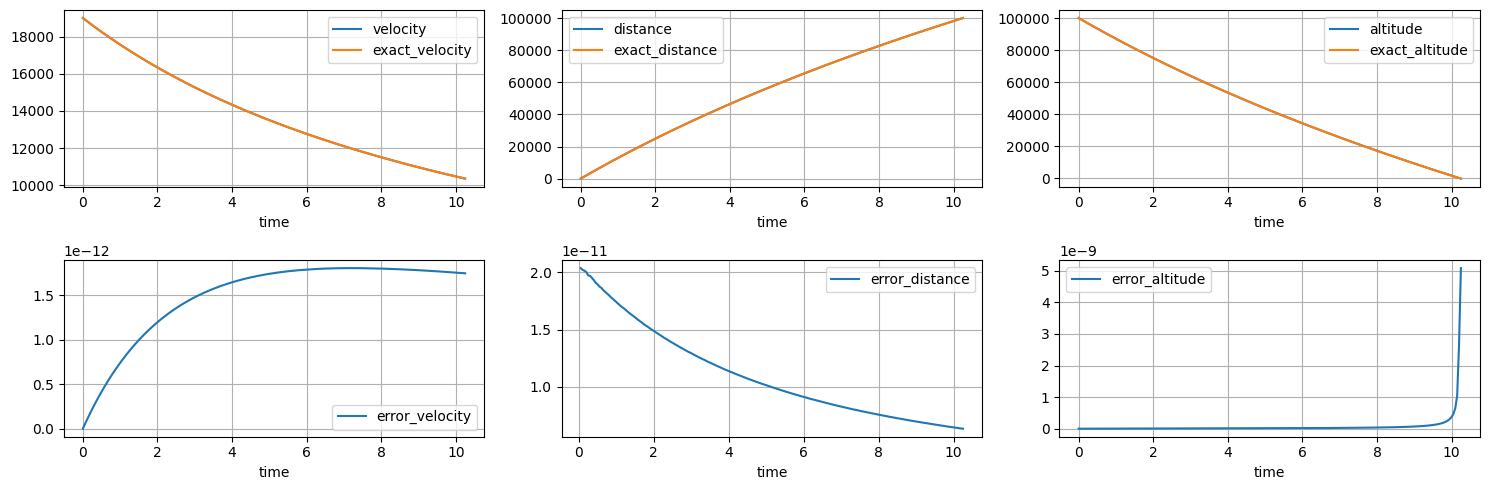

In [29]:
earth = deepimpact.Planet(
    atmos_func='constant', # flat earth
    g=0, # Surface gravity (m/s^2) (no gravity)
    Q=0, # The heat of ablation (J/kg) (no haet of ablation)
    Cl=0, # Lift coefficient (no lift)
    # use the default values for the rest of the parameters
)

# Solve the atmospheric entry problem for a given set of input parameters
result = earth.solve_atmospheric_entry(
    dt=0.05,
    angle=45,
    radius=35,
    strength=1e7,
    density=3000,
    velocity=19e3,
    ode_method="rk4",
)

def plot_atmospheric_entry(result, col_name, exact_func, ax1, ax2):
    result['exact_' + col_name] = exact_func(result.time)
    result['error_' + col_name] = np.abs(((result['exact_' + col_name] - result[col_name]))) / np.abs(result['exact_' + col_name])
    result.plot(x='time', y=[col_name, 'exact_' + col_name], ax=ax1, grid=True)
    result.plot(x='time', y=['error_' + col_name], ax=ax2, grid=True, scaley='log')

fig, axes = plt.subplots(2, 3, figsize=(15, 5))
plot_atmospheric_entry(result, 'velocity', exact_vt, axes[0, 0], axes[1, 0])
plot_atmospheric_entry(result, 'distance', exact_xt, axes[0, 1], axes[1, 1])
plot_atmospheric_entry(result, 'altitude', exact_zt, axes[0, 2], axes[1, 2])
plt.tight_layout()


The above plots show us that the numerical solution is matching the exact solution by an error of less than 1e-9.

### 2) Analysis for the airburst scenario:

Let's consider the following set of parameters:

In [30]:
airburst_input = {
    'dt': 0.05, # The time step to use
    'angle': 20, # The initial trajectory angle of the asteroid to the horizontal
    'radius': 9.75, # The initial radius of the asteroid in meters
    'strength': 2e6, # The strength of the asteroid in Pa
    'density': 3300., # The density of the asteroid in kg / m^3
    'velocity': 19e3, # The entery speed of the asteroid in meters/second
    'init_altitude': 100e3, # The initial altitude of the asteroid in meters
}


Let's solve and plot the airburst scenario (under an exponential atmosphere):

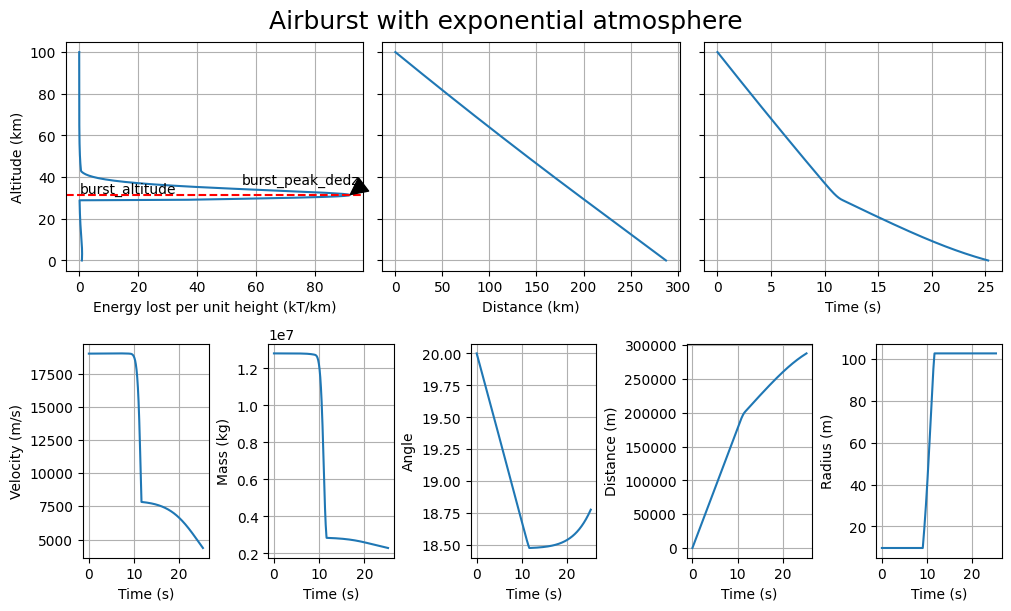

In [31]:
earth = Planet(atmos_func='exponential')
result = earth.solve_atmospheric_entry(**airburst_input, radians=False)
energy = earth.calculate_energy(result)
airburst_outcome = earth.analyse_outcome(energy)
plot_analytical_case(result, airburst_outcome, figsize=(10, 6), title="Airburst with exponential atmosphere")


As we can see, the airburst scenario is consistent with the expected results. The meteoroid reaches the burst altitude close to ~10s, behaviour consistent with all the plots shown above. Also, it's very clear the effect of the airburst effect in the angle (making it change its trajectory) as well as all the other variables. The sudden change in the radius demonstrates the moment where the meteoroid quickly starts to break apart.

Now, let's solve and plot the airburst scenario (under an tabular atmosphere):

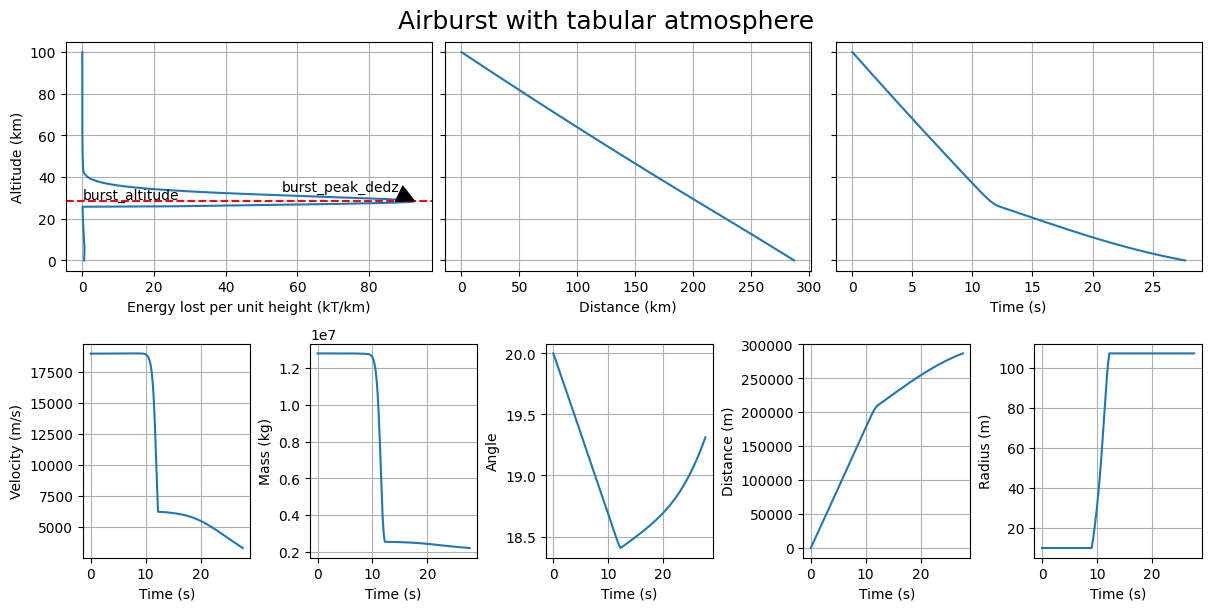

In [32]:
earth = Planet(atmos_func='tabular')
result = earth.solve_atmospheric_entry(**airburst_input, radians=False)
energy = earth.calculate_energy(result)
airburst_outcome = earth.analyse_outcome(energy)
plot_analytical_case(result, airburst_outcome, figsize=(12, 6), title="Airburst with tabular atmosphere")


Similarly to the previous scenario, using a tabular atmosphere doesn't change the behaviour of the meteoroid that much in comparison with the previous scenario.

### 3) Analysis for the cratering scenario:

Let's consider the following set of parameters:

In [ ]:
cratering_input = {
    'radius': 50,
    'angle': 90,
    'strength': 2e7,
    'velocity': 20e3,
    'density': 7000.,
    'radians': False,
    'init_altitude': 100e3,
}


Let's solve and plot the cratering scenario (under an exponential atmosphere):

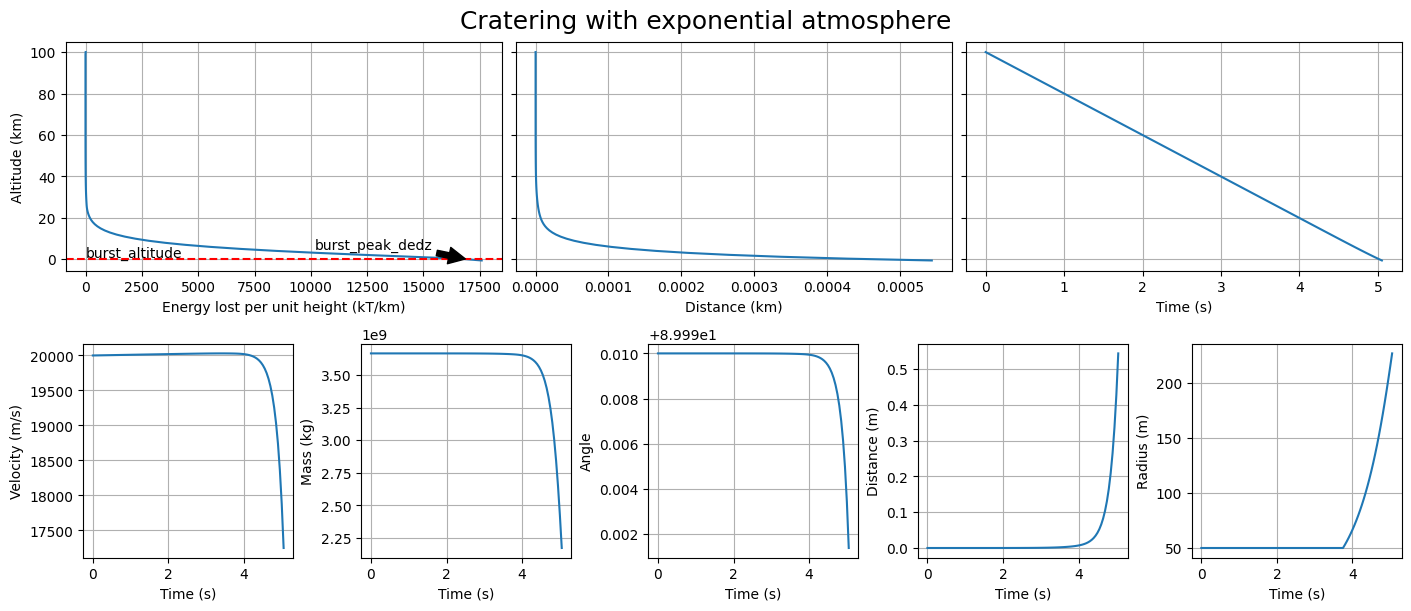

In [ ]:
earth = Planet(atmos_func='exponential')
result = earth.solve_atmospheric_entry(**cratering_input)
energy = earth.calculate_energy(result)
airburst_outcome = earth.analyse_outcome(energy)
plot_analytical_case(result, airburst_outcome, figsize=(14, 6), title="Cratering with exponential atmosphere")


Notice that, again, results are consistent with the expected point of the burst atitude zero.The meteoroid  reaches the burst altitude 0 close to 5 seconds. Note that radius starts to increase in function of the mass, which 

Now let's solve under a tabular atmosphere:

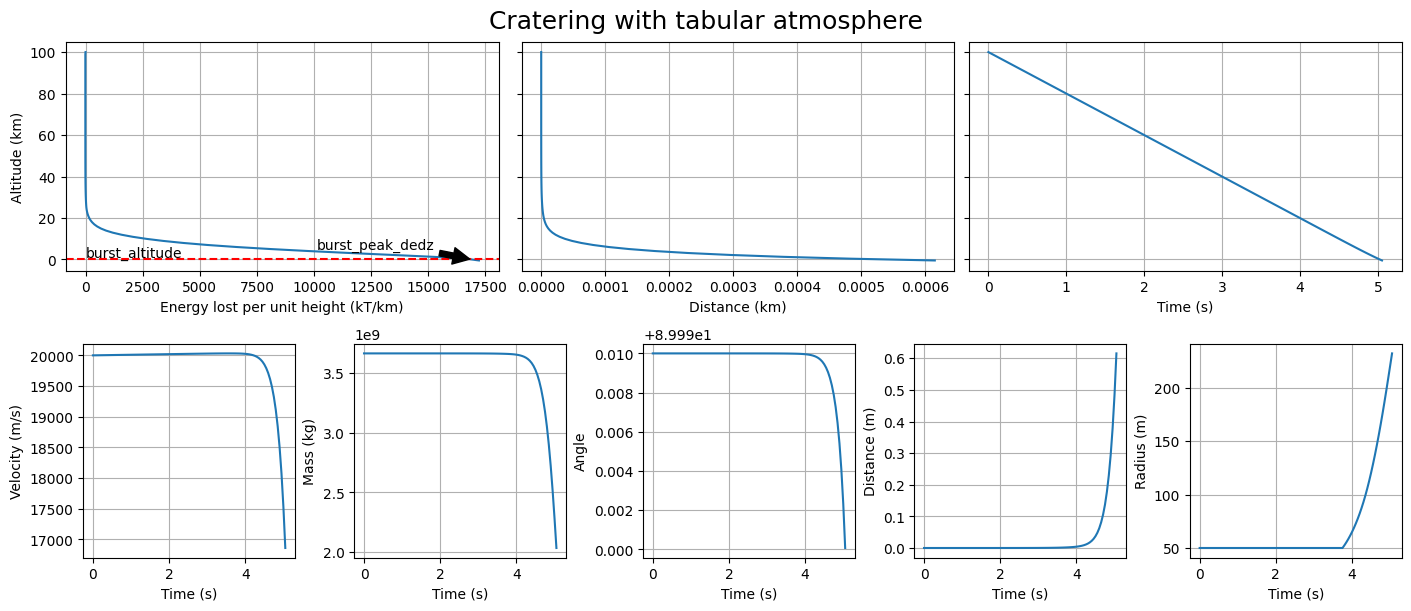

In [40]:
earth = Planet(atmos_func='tabular')
result = earth.solve_atmospheric_entry(**cratering_input)
energy = earth.calculate_energy(result)
airburst_outcome = earth.analyse_outcome(energy)
plot_analytical_case(result, airburst_outcome, figsize=(14, 6), title="Cratering with tabular atmosphere")


Finally, the above figure shows the results for the cratering under a tabular surface.Again, the new atmosphere is not very impactful in the results.

# Convergence Error Analysis: Runge-Kutta 4th Order

### 1) Analytical Case (No Lift, No Gravity, No Ablation, Flat Planet):


In [41]:
planet_input = {
    'dt': 0.05, # The time step to use
    'angle': 20, # The initial trajectory angle of the asteroid to the horizontal
    'radius': 9.75, # The initial radius of the asteroid in meters
    'strength': 2e6, # The strength of the asteroid in Pa
    'density': 3300., # The density of the asteroid in kg / m^3
    'velocity': 19e3, # The entery speed of the asteroid in meters/second
    'init_altitude': 100e3, # The initial altitude of the asteroid in meters
}
atmosphere = 'constant'
planet = Planet(atmos_func=atmosphere, g=0, Q=0, Cl=0)
result = planet.solve_atmospheric_entry(**planet_input)
result = planet.calculate_energy(result)
outcome = planet.analyse_outcome(result)
pd.DataFrame(outcome, index=[0])


,outcome,burst_peak_dedz,burst_altitude,burst_distance,burst_energy
0,Airburst,44.038647,99677.220487,886.829424,538.315929


In [42]:
error_analysis = AtmosphericErrorAnalysis()


In [43]:
ode_method = ['improved_euler', 'rk4']
dt_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
errors = error_analysis.error_analysis(dt_values, cratering_input, ode_method, planet)
errors['rk4']


,distance,velocity,altitude,angle,mass,radius,dt
0.00001,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.00001
0.00010,2.565488e-20,0.000068,0.000419,0.0,0.0,0.0,0.00010
0.00100,2.567493e-20,0.000068,0.000419,0.0,0.0,0.0,0.00100
0.01000,4.898308e-20,0.000114,0.000800,0.0,0.0,0.0,0.01000
0.10000,5.190950e-20,0.000077,0.000848,0.0,0.0,0.0,0.10000


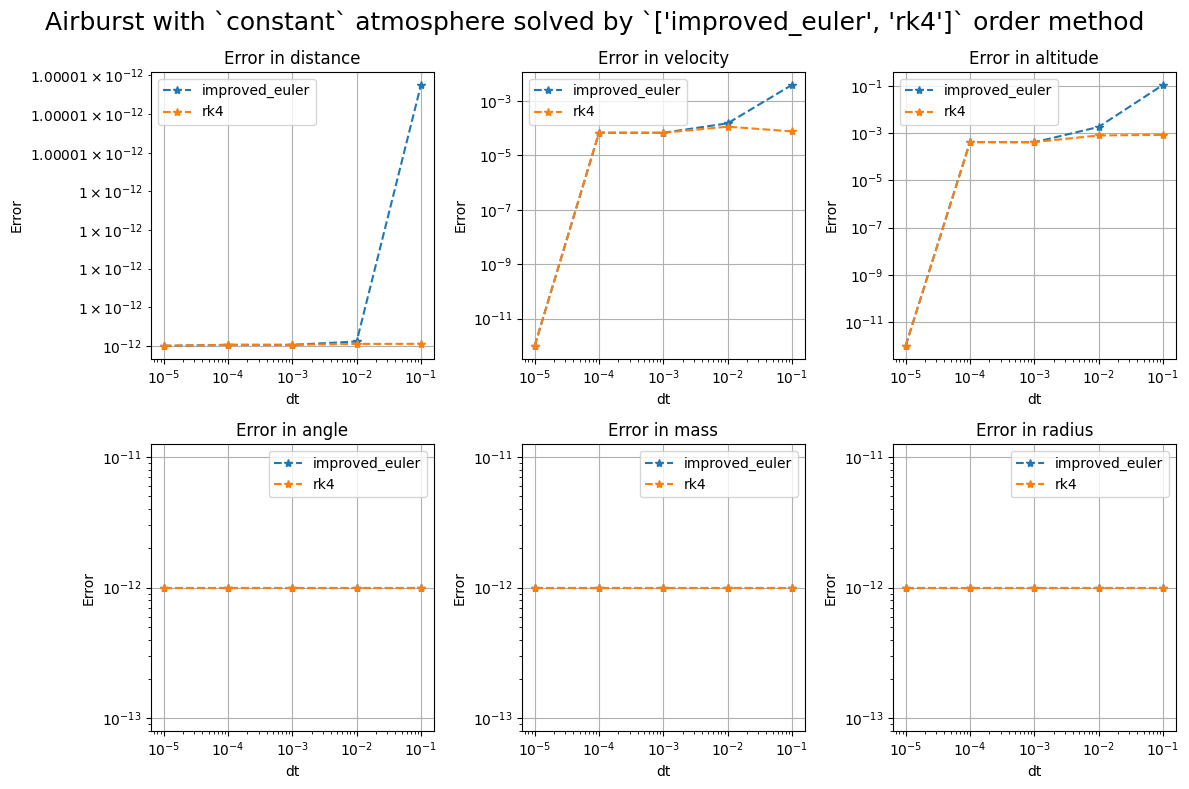

In [44]:
title = f'{outcome["outcome"]} with `{atmosphere}` atmosphere solved by `{ode_method}` order method'
error_analysis.plot_analysis(errors, title, figsize=(12, 8))


As it's possible to see above, we already start with a small error for most of the variables, except by the velocity and altitude. Note that this error is obtained froma comparison with the results of the exact analytical equations. Also, note that error goes to almost zero as dt reaches 1e-5. This is not the time step used by our solver as default, though. The default value is 0.05, which is a good compromise between accuracy and speed (using smaller time steps such as 1e-3 or 1e-4 would yield negligible improvements in the results, while would take much longer to run). With 1e-5, results would increase considerably, but the time to run would also increase considerably. Thus the compromise. Finally, notice that Runge-Kutta 4th order is slightly better than the Improved Euler's method, as expected.

### 2) Airburst Case (with exponential atmosphere):

In [63]:
planet_input = {
    'dt': 0.05, # The time step to use
    'angle': 20, # The initial trajectory angle of the asteroid to the horizontal
    'radius': 9.75, # The initial radius of the asteroid in meters
    'strength': 2e6, # The strength of the asteroid in Pa
    'density': 3300., # The density of the asteroid in kg / m^3
    'velocity': 19e3, # The entery speed of the asteroid in meters/second
    'init_altitude': 100e3, # The initial altitude of the asteroid in meters
}
atmosphere = 'exponential'
planet = Planet(atmos_func=atmosphere)
result = planet.solve_atmospheric_entry(**planet_input)
result = planet.calculate_energy(result)
outcome = planet.analyse_outcome(result)
pd.DataFrame(outcome, index=[0])


,outcome,burst_peak_dedz,burst_altitude,burst_distance,burst_energy
0,Airburst,91.737702,31416.61196,194052.890766,358.264571


In [64]:
ode_method = ['improved_euler', 'rk4']
dt_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
error_analysis = AtmosphericErrorAnalysis()
errors = error_analysis.error_analysis(dt_values, cratering_input, ode_method, planet)
errors['rk4']


,distance,velocity,altitude,angle,mass,radius,dt
0.00001,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00001
0.00010,0.052974,300.997445,54.385510,0.000903,1.785090e+08,41.297125,0.00010
0.00100,0.053210,302.368446,54.633541,0.000907,1.791705e+08,41.347559,0.00100
0.01000,0.054446,309.767697,55.935793,0.000930,1.827065e+08,41.586244,0.01000
0.10000,0.095004,551.262699,99.382576,0.001715,2.848567e+08,48.517871,0.10000


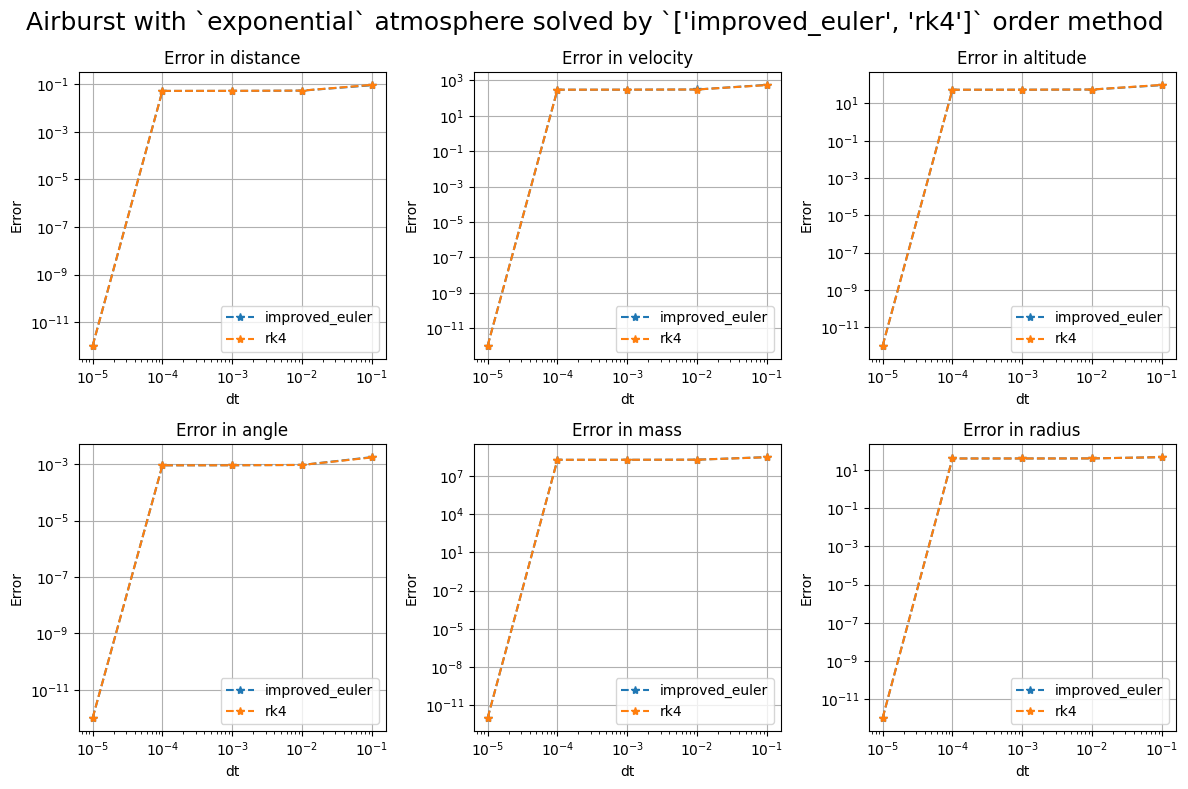

In [47]:
title = f'{outcome["outcome"]} with `{atmosphere}` atmosphere solved by `{ode_method}` order method'
error_analysis.plot_analysis(errors, title, figsize=(12, 8))


Similarly to the previous case, values of dt equal to 1e-5 would yield the best results. Also notice that, differently from before, we don't have the exact analytical solution available for us anymore. Thus we rely on the scipy ode solver to obtain our results to be compared against our solver solutions. While not ideal, it does show us that our solver is working as expected, with time steps decreasing the errors as we decrease the time step.

### 3) Airburst Case (with tabular atmosphere):

In [48]:
planet_input = {
    'dt': 0.05, # The time step to use
    'angle': 20, # The initial trajectory angle of the asteroid to the horizontal
    'radius': 9.75, # The initial radius of the asteroid in meters
    'strength': 2e6, # The strength of the asteroid in Pa
    'density': 3300., # The density of the asteroid in kg / m^3
    'velocity': 19e3, # The entery speed of the asteroid in meters/second
    'init_altitude': 100e3, # The initial altitude of the asteroid in meters
}
atmosphere = 'tabular'
planet = Planet(atmos_func=atmosphere)
result = planet.solve_atmospheric_entry(**planet_input)
result = planet.calculate_energy(result)
outcome = planet.analyse_outcome(result)
pd.DataFrame(outcome, index=[0])


,outcome,burst_peak_dedz,burst_altitude,burst_distance,burst_energy
0,Airburst,92.777858,28433.5987,202913.140915,371.374039


In [49]:
ode_method = ['improved_euler', 'rk4']
dt_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
error_analysis = AtmosphericErrorAnalysis()
errors = error_analysis.error_analysis(dt_values, cratering_input, ode_method, planet)
errors['rk4']


,distance,velocity,altitude,angle,mass,radius,dt
0.00001,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00001
0.00010,0.062356,361.010539,64.363349,0.001092,2.069665e+08,42.537391,0.00010
0.00100,0.062665,362.755792,64.691857,0.001098,2.077581e+08,42.595364,0.00100
0.01000,0.066296,383.032673,68.548488,0.001162,2.168740e+08,43.282942,0.01000
0.10000,0.110379,623.934505,116.241577,0.001957,3.135527e+08,49.936921,0.10000


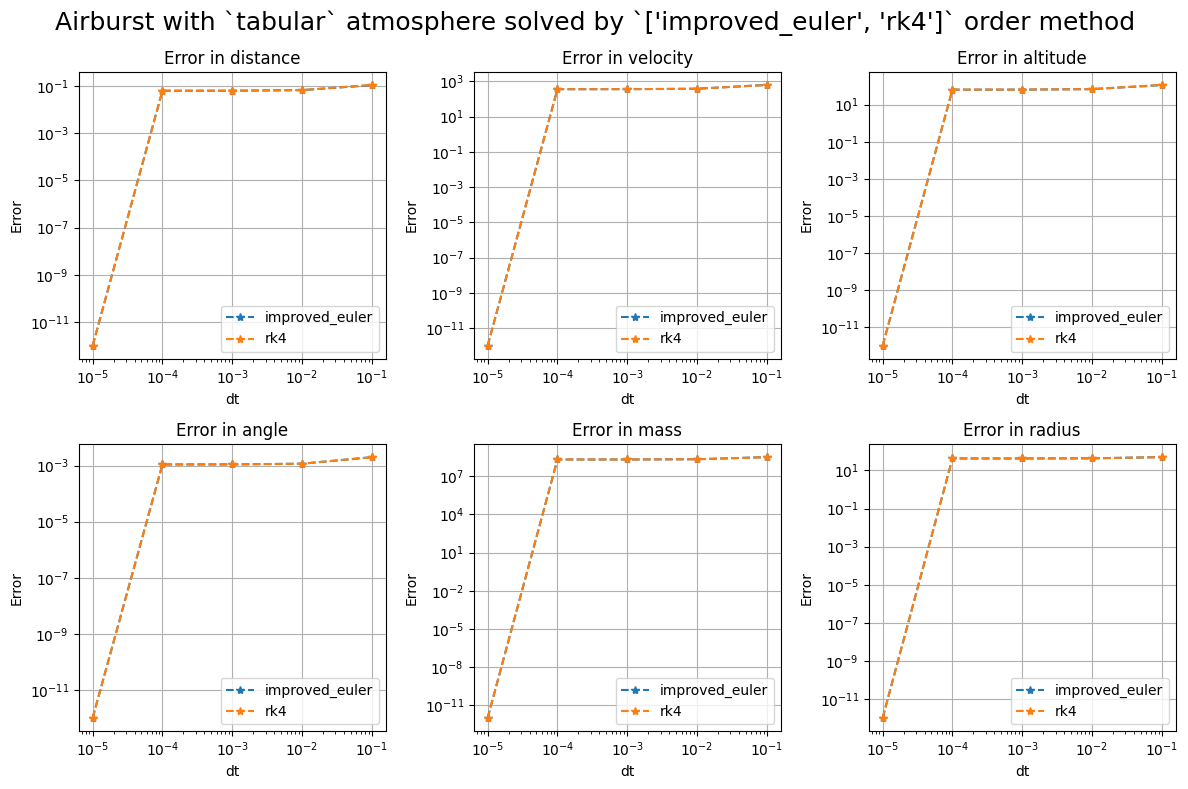

In [50]:
title = f'{outcome["outcome"]} with `{atmosphere}` atmosphere solved by `{ode_method}` order method'
error_analysis.plot_analysis(errors, title, figsize=(12, 8))


This case is very similar to the above case. So the same arguments applies. Including the compromising we made about choosing a slitghly worse dt to run the code faster.

### 4) Cratering Case (with exponential atmosphere):

In [51]:
planet_input = {
    'radius': 50,
    'angle': 90,
    'strength': 2e7,
    'velocity': 20e3,
    'density': 7000.,
    'radians': False,
    'init_altitude': 100e3,
}
atmosphere = 'exponential'
planet = Planet(atmos_func=atmosphere)
result = planet.solve_atmospheric_entry(**planet_input)
result = planet.calculate_energy(result)
outcome = planet.analyse_outcome(result)
pd.DataFrame(outcome, index=[0])


,outcome,burst_peak_dedz,burst_altitude,burst_distance,burst_energy
0,Cratering,16945.809904,-1.762146e-12,0.469797,86998.643483


In [52]:
ode_method = ['improved_euler', 'rk4']
dt_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
error_analysis = AtmosphericErrorAnalysis()
errors = error_analysis.error_analysis(dt_values, cratering_input, ode_method, planet)
errors['rk4']


,distance,velocity,altitude,angle,mass,radius,dt
0.00001,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00001
0.00010,0.052974,300.997445,54.385510,0.000903,1.785090e+08,41.297125,0.00010
0.00100,0.053210,302.368446,54.633541,0.000907,1.791705e+08,41.347559,0.00100
0.01000,0.054446,309.767697,55.935793,0.000930,1.827065e+08,41.586244,0.01000
0.10000,0.095004,551.262699,99.382576,0.001715,2.848567e+08,48.517871,0.10000


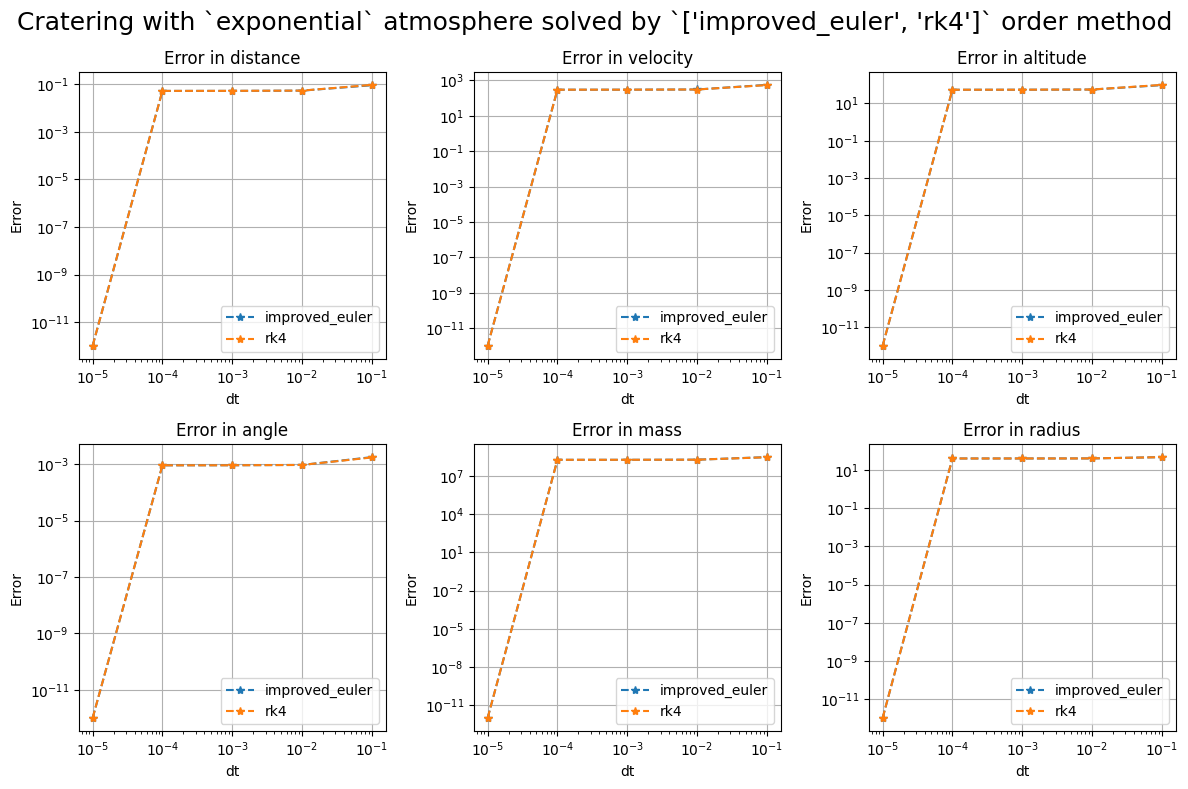

In [53]:
title = f'{outcome["outcome"]} with `{atmosphere}` atmosphere solved by `{ode_method}` order method'
error_analysis.plot_analysis(errors, title, figsize=(12, 8))


The above image also reflects the same results as before.

### 4) Cratering Case (with tabular atmosphere):

In [54]:
cratering_input = {
    'radius': 50,
    'angle': 90,
    'strength': 2e7,
    'velocity': 20e3,
    'density': 7000.,
    'radians': False,
    'init_altitude': 100e3,
}
atmosphere = 'tabular'
planet = Planet(atmos_func=atmosphere)
result = planet.solve_atmospheric_entry(**cratering_input)
result = planet.calculate_energy(result)
outcome = planet.analyse_outcome(result)
pd.DataFrame(outcome, index=[0])


,outcome,burst_peak_dedz,burst_altitude,burst_distance,burst_energy
0,Cratering,16897.681625,6.878054e-12,0.54171,77239.820397


In [55]:
ode_method = ['improved_euler', 'rk4']
dt_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
error_analysis = AtmosphericErrorAnalysis()
errors = error_analysis.error_analysis(dt_values, cratering_input, ode_method, planet)
errors['rk4']


,distance,velocity,altitude,angle,mass,radius,dt
0.00001,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00001
0.00010,0.062356,361.010539,64.363349,0.001092,2.069665e+08,42.537391,0.00010
0.00100,0.062665,362.755792,64.691857,0.001098,2.077581e+08,42.595364,0.00100
0.01000,0.066296,383.032673,68.548488,0.001162,2.168740e+08,43.282942,0.01000
0.10000,0.110379,623.934505,116.241577,0.001957,3.135527e+08,49.936921,0.10000


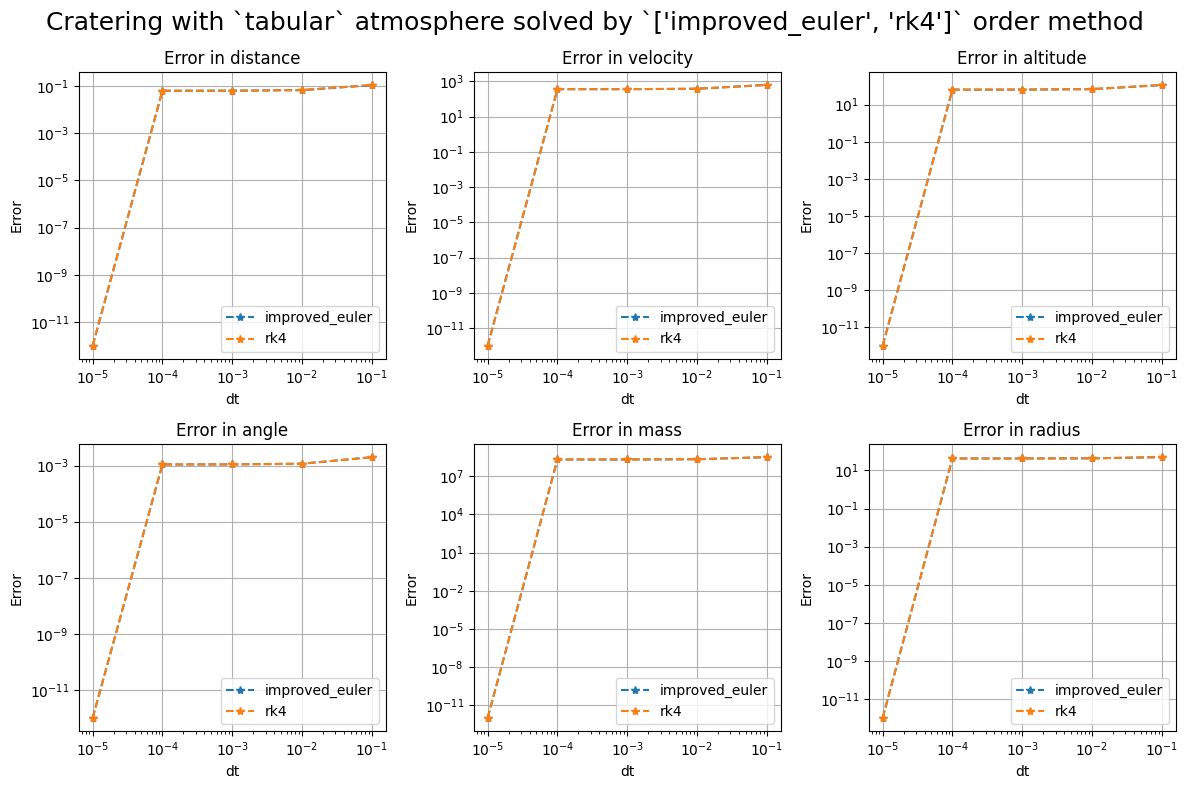

In [56]:
title = f'{outcome["outcome"]} with `{atmosphere}` atmosphere solved by `{ode_method}` order method'
error_analysis.plot_analysis(errors, title, figsize=(12, 8))


Again, the same arguments as before applies here.

## Checking How The Asteroid Path Varies With Each Parameter

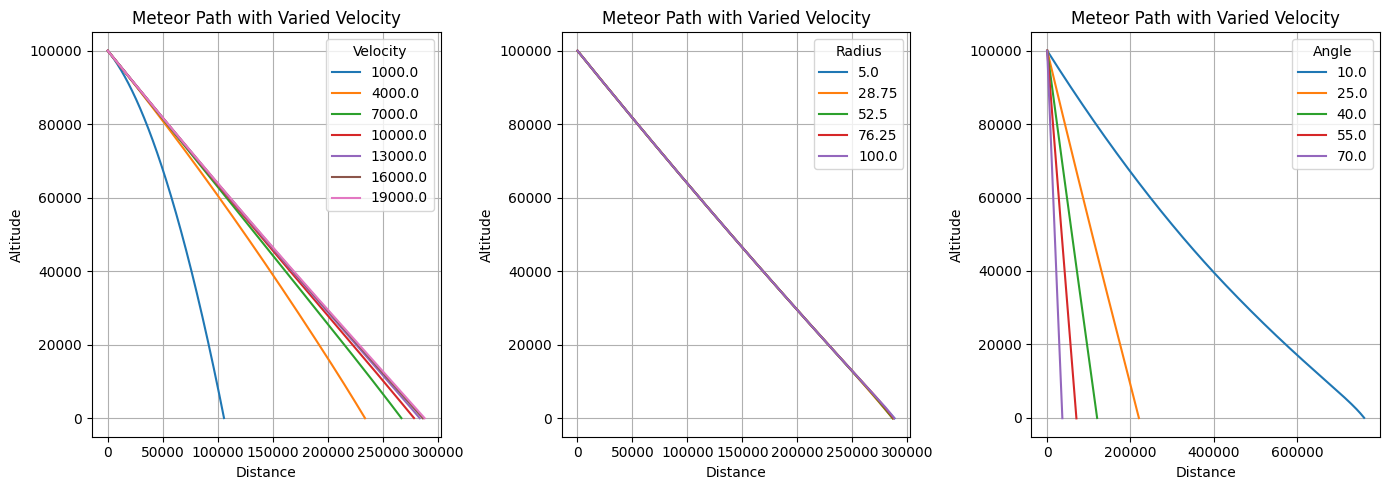

In [57]:


# Assume 'solve' is an instance of a class with the required methods
planet_input = {
    'radius': 9.75,
    'angle': 20,
    'strength': 2e6,
    'velocity': 20e3,
    'density': 3300.,
    'radians': False,
    'init_altitude': 100e3,
}
atmosphere = 'exponential'
planet = Planet(atmos_func=atmosphere)
param_values = {
    'velocity': np.linspace(1000,19000,7),
    'radius': np.linspace(5,100,5),
    'angle': np.linspace(10,70,5),
}
plot_meteor_paths(param_values, planet, planet_input, figsize=(14, 5))


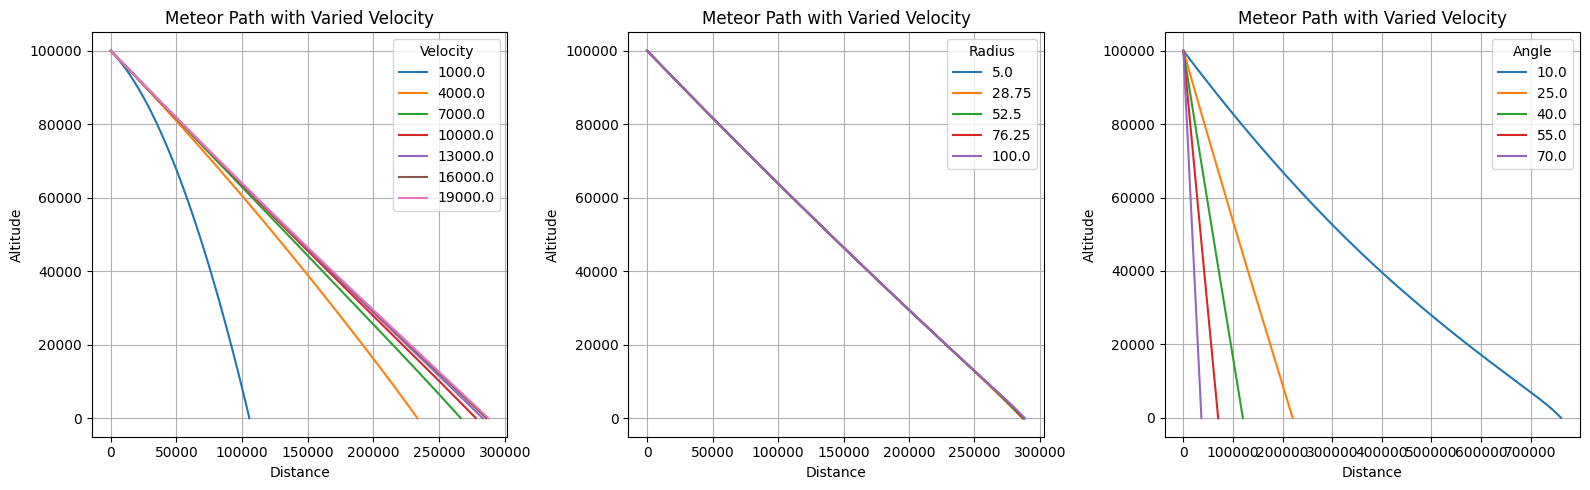

In [58]:
# Assume 'solve' is an instance of a class with the required methods
planet_input = {
    'radius': 9.75,
    'angle': 20,
    'strength': 2e6,
    'velocity': 20e3,
    'density': 3300.,
    'radians': False,
    'init_altitude': 100e3,
}
atmosphere = 'exponential'
planet = Planet(atmos_func=atmosphere)
param_values = {
    'velocity': np.linspace(1000,19000,7),
    'radius': np.linspace(5,100,5),
    'angle': np.linspace(10,70,5),
}
plot_meteor_paths(param_values, planet, planet_input, figsize=(16, 5))


# Performance Analysis #

### 1) Airburst Case (small angle of entry)

In [59]:
%%timeit
planet_input = {
    'dt': 0.05, # The time step to use
    'angle': 20, # The initial trajectory angle of the asteroid to the horizontal
    'radius': 9.75, # The initial radius of the asteroid in meters
    'strength': 2e6, # The strength of the asteroid in Pa
    'density': 3300., # The density of the asteroid in kg / m^3
    'velocity': 19e3, # The entery speed of the asteroid in meters/second
    'init_altitude': 100e3, # The initial altitude of the asteroid in meters
}
atmosphere = 'exponential'
planet = Planet(atmos_func=atmosphere)
result = planet.solve_atmospheric_entry(**planet_input)
result = planet.calculate_energy(result)
outcome = planet.analyse_outcome(result)


109 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1) Airburst Case (bigger angle of entry)

In [60]:
%%timeit
planet_input = {
    'dt': 0.05, # The time step to use
    'angle': 90, # The initial trajectory angle of the asteroid to the horizontal
    'radius': 9.75, # The initial radius of the asteroid in meters
    'strength': 2e6, # The strength of the asteroid in Pa
    'density': 3300., # The density of the asteroid in kg / m^3
    'velocity': 19e3, # The entery speed of the asteroid in meters/second
    'init_altitude': 100e3, # The initial altitude of the asteroid in meters
}
atmosphere = 'exponential'
planet = Planet(atmos_func=atmosphere)
result = planet.solve_atmospheric_entry(**planet_input)
result = planet.calculate_energy(result)
outcome = planet.analyse_outcome(result)


41.4 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1) Airburst Case (small angle of improved euler)

In [61]:
%%timeit
planet_input = {
    'dt': 0.05, # The time step to use
    'angle': 40, # The initial trajectory angle of the asteroid to the horizontal
    'radius': 9.75, # The initial radius of the asteroid in meters
    'strength': 2e6, # The strength of the asteroid in Pa
    'density': 3300., # The density of the asteroid in kg / m^3
    'velocity': 19e3, # The entery speed of the asteroid in meters/second
    'init_altitude': 100e3, # The initial altitude of the asteroid in meters
    'ode_method': 'improved_euler'
}
atmosphere = 'exponential'
planet = Planet(atmos_func=atmosphere)
result = planet.solve_atmospheric_entry(**planet_input)
result = planet.calculate_energy(result)
outcome = planet.analyse_outcome(result)


47 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
#ChatGPT was used for this block of code
times=[]
planet_input = {
    'angle': 40, # The initial trajectory angle of the asteroid to the horizontal
    'radius': 9.75, # The initial radius of the asteroid in meters
    'strength': 2e6, # The strength of the asteroid in Pa
    'density': 3300., # The density of the asteroid in kg / m^3
    'velocity': 19e3, # The entery speed of the asteroid in meters/second
    'init_altitude': 100e3, # The initial altitude of the asteroid in meters
}
atmosphere = 'exponential'
planet = Planet(atmos_func=atmosphere)
for dt in [10**-4,10**-3,10**-2,10**-1,1]:
    time = %timeit -o -r 1 -n 1 planet.solve_atmospheric_entry(**planet_input, dt=dt, dt_ode=dt, ode_method='rk4')
    times.append(time.best)


26.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
279 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
27.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/mandraco/Documents/ACSE/assesment/acs-deepimpact-atira/analysis/../deepimpact/solver.py:205: RuntimeWarning: invalid value encountered in scalar power
  radius = (3.0 * mass / (4.0 * np.pi * density)) ** (1.0 / 3.0)


In [ ]:
plt.loglog([10**-4,10**-3,10**-2,10**-1,1],times)
plt.xlabel('$\Delta t$')
plt.ylabel('Time for 1 loop and 5 runs (s)')
plt.grid(True)
plt.title('Performance with Different Time-Steps (RK4)')


In [ ]:
#ChatGPT was used for this block of code
times=[]
planet_input = {
    'dt': 0.05, # The time step to use
    'angle': 40, # The initial trajectory angle of the asteroid to the horizontal
    'radius': 9.75, # The initial radius of the asteroid in meters
    'strength': 2e6, # The strength of the asteroid in Pa
    'density': 3300., # The density of the asteroid in kg / m^3
    'velocity': 19e3, # The entery speed of the asteroid in meters/second
    'init_altitude': 100e3, # The initial altitude of the asteroid in meters
}
atmosphere = 'exponential'
planet = Planet(atmos_func=atmosphere)
for dt in [10**-4,10**-3,10**-2,10**-1,1]:
    time = %timeit -o -r 1 -n 1 planet.solve_atmospheric_entry(radius, velocity, density, strength, angle, dt=dt, dt_ode=dt, ode_method='improved_euler')
    times.append(time.best)


In [ ]:
plt.loglog([10**-4,10**-3,10**-2,10**-1,1],times)
plt.xlabel('$\Delta t$')
plt.ylabel('Time for 1 loop and 5 runs (s)')
plt.grid(True)
plt.title('Performance with Different Time-Steps (improved euler)')


### Chelyabinsk extended optimization

In [ ]:
import pandas as pd
from deepimpact import Planet
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d

chelyabinsk_data = pd.read_csv('../resources/ChelyabinskEnergyAltitude.csv')
chelyabinsk_data.columns = ['chely_h', 'chely_dedz']
chelyabinsk_data['chely_h'] = chelyabinsk_data['chely_h']*1000

def solver_output(r, Y):
    input = {'radius': r,
            'velocity': 19e3,
            'density': 3300.,
            'strength': Y,
            'angle': 20,
            'init_altitude': 100e3,
            'dt':0.05}

    earth = Planet()
    result = earth.solve_atmospheric_entry(**input, radians=False)
    result = earth.calculate_energy(result)
    result = result[['altitude','dedz']]
    return result

def loss_func(solver,chelyabinsk, metric='peak_distantce'):
    # max_value_index = chelyabinsk['chely_dedz'].idxmax()
    # # Get all rows up to and including the row with the maximum value
    # chelyabinsk = chelyabinsk.loc[:max_value_index]
    if metric == 'peak_distantce': 
        chelyabinsk_max_dedz_z= 29557.8
        chely_max_dedz = 81.50500

        solver_max_dedz_index = solver['dedz'].idxmax()
        solver_max_dedz_z = solver.loc[solver_max_dedz_index, 'altitude']
        solver_max_dedz = solver['dedz'].max()
        metric = np.sqrt((chelyabinsk_max_dedz_z-solver_max_dedz_z)**2+(chely_max_dedz-solver_max_dedz)**2)*abs(chely_max_dedz-solver_max_dedz)*abs(chelyabinsk_max_dedz_z-solver_max_dedz_z)
        return metric
    else: 
        x_known = solver['altitude'] # Known x-values
        y_known = solver['dedz'] # Corresponding y-values
        # New x values for interpolation/extrapolation
        x_new = chelyabinsk['chely_h']
        # Create an interpolation function (default is linear interpolation)
        f_linear = interp1d(x_known, y_known)
        # Use the interpolation functions to estimate y values for the new x values
        interpolated_solver_dedz = f_linear(x_new)
        #y_cubic = f_cubic(x_new)

        squared_diff = (interpolated_solver_dedz - chelyabinsk['chely_h']) ** 2
        # Compute the mean of squared differences
        mse = np.mean(squared_diff)
        # Compute the RMSE (square root of the mean squared error)
        rmse = np.sqrt(mse)
        return rmse

def optimization_function(params):
    r, Y = params
    solver_data = solver_output(r, Y)
    return loss_func(solver_data, chelyabinsk_data)

def get_initail_guess():
# Generating 100 points between 1e6 and 3e6
    limit_list = np.linspace(1e6, 5e6, 20)
    radius_list = np.linspace(2, 20, 20)

    chelyabinsk_max_dedz_z= 29557.8
    chely_max_dedz = 81.50500

    strength = []
    radius = []
    metric_list = []

    for Y in limit_list:
        for r in radius_list:
            solver_solution = solver_output(r,Y)
            solver_max_dedz_index = solver_solution['dedz'].idxmax()
            solver_max_dedz_z = solver_solution.loc[solver_max_dedz_index, 'altitude']
            solver_max_dedz = solver_solution['dedz'].max()
            metric = np.sqrt((chelyabinsk_max_dedz_z-solver_max_dedz_z)**2+(chely_max_dedz-solver_max_dedz)**2)*abs(chely_max_dedz-solver_max_dedz)*abs(chelyabinsk_max_dedz_z-solver_max_dedz_z)
            strength.append(Y)
            radius.append(r)
            metric_list.append(metric)

    # Retrieve the corresponding elements from limit and radius
    min_index = metric_list.index(min(metric_list))
    optimal_strength = strength[min_index]
    optimal_radius = radius[min_index]
    smallest_metric = metric_list[min_index]
    optimal_param = [optimal_radius,optimal_strength ]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Plot the data
    ax.scatter(optimal_strength, optimal_radius, smallest_metric,  color='red')
    ax.scatter(strength, radius, metric_list)
    # Set labels for axes
    ax.set_xlabel('Limit')
    ax.set_ylabel('Radius')
    ax.set_zlabel('Metric')
    # Show the plot
    plt.show()
    return optimal_param

# Initial guess for r and Y
initial_guess_param = get_initail_guess()
initial_guess = [initial_guess_param[0], initial_guess_param[1]]
bounds = [(1, 20), (1e6, 5e6)]
# Perform the minimization
result = minimize(optimization_function, initial_guess, bounds=bounds, method='Nelder-Mead')
# Extract the optimal values
optimal_r, optimal_Y = result.x
print(f"Optimal Radius: {optimal_r}, Optimal Yield Strength: {optimal_Y}")
optimal_result = solver_output(r=optimal_r,Y=optimal_Y)

plt.figure(figsize=(10, 6))
plt.plot(optimal_result['altitude'],optimal_result['dedz'], label=f"Optimal Radius: {optimal_r} \nOptimal Yield Strength: {optimal_Y}")
plt.plot(chelyabinsk_data['chely_h'],chelyabinsk_data['chely_dedz'], label='Chelyabinsk Data')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolation Examples')
plt.grid(True)
plt.show()

print(optimization_function(initial_guess))
print(optimization_function(result.x))


## Solver extended - Part 2

In [ ]:
import pandas as pd
import numpy as np
import deepimpact
from deepimpact import Planet
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


### Determine asteroid parameters (e.g., strength and radius) that best fit an observed energy deposition curve

Density 3300 kg/m, impact angle (18.3 degrees to horizontal) and entry velocity (19.2 km/s)


In [ ]:
chelyabinsk_df = pd.read_csv('../resources/ChelyabinskEnergyAltitude.csv')


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(chelyabinsk_df['Energy Per Unit Length (kt Km^-1)'],chelyabinsk_df['Height (km)'])
plt.title('Energy Per Unit Length vs. Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel('Energy Per Unit Length (kt Km^-1)')
plt.grid(True)
plt.show()


Given an energy vs height curve, we approximate asteroid parameters(strength and radius): 

Density, Impact angle and velocity are constant, we need to vary strenght and radius to match the Energy per Height. 

Call calculate energy function
inputs a pandas dataframe with columns for the velocity, mass, angle,
altitude, horizontal distance and radius as a function of time

Returns : DataFrame 
Returns the dataframe with additional column ``dedz`` which is the
kinetic energy lost per unit altitude


Density 3300 kg/m, impact angle (18.3 degrees to horizontal) and entry velocity (19.2 km/s)

In [ ]:
def approx_curve(strength,radius):
    """
    Calculates and returns the energy deposition curve of an atmospheric entry event 
    based on specified parameters for strength and radius. 
    Parameters:
    - strength (float): The strength of the object entering the atmosphere.
    - radius (float): The radius of the object entering the atmosphere.

    The function internally sets the velocity and angle of the atmospheric entry 
    as well as the density of the object. It then uses a 'Planet' class instance 
    to simulate the atmospheric entry and to calculate the energy deposition. 
    The energy is calculated over various altitudes and returned as a DataFrame

    Outputs:
    - A DataFrame containing the altitude (in km) and the energy per unit length 
      (dedz) for the simulated atmospheric entry event. The DataFrame columns are 
      'altitude', 'dedz', and 'Height (km)', where 'Height (km)' is derived from 
      'altitude' converted from meters to kilometers.
    """
    velocity = 19200
    angle = 18.3
    density = 3300
    strength, radius = strength, radius
    planet_ = Planet()
    result = planet_.solve_atmospheric_entry(radius,velocity,density,strength, angle)
    df_energy = planet_.calculate_energy(result)
    df_exp = df_energy[['altitude','dedz']]
    df_exp['Height (km)'] = df_exp['altitude']/1000
    return df_exp


In [ ]:
df_energy = approx_curve(5e6,8.2)


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_energy['dedz'],df_energy['altitude']/1000,)
plt.title('Energy Per Unit altitude vs. Altitude')
plt.xlabel('dedz')
plt.ylabel('Altitude (km)')
plt.grid(True)
plt.show()


In [ ]:
def plot_calculate_diff(strength,radius):
    """
    Plots and compares the observed energy deposition curve from the Chelyabinsk event 
    with a simulated curve based on specified strength and radius parameters. This function 
    calculates and displays the Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) 
    between the observed and simulated curves. Additionally, it compares the peak energies 
    and burst altitudes of both curves to provide feedback on the adequacy of the provided 
    strength and radius parameters.

    Parameters:
    - strength (float): The strength parameter used to generate the simulated energy curve.
    - radius (float): The radius parameter used to generate the simulated energy curve.

    The function assumes the availability of a global DataFrame 'chelyabinsk_df' containing 
    the observed data for the Chelyabinsk event with columns 'Height (km)' and 
    'Energy Per Unit Length (kt Km^-1)'. It also uses an 'approx_curve' function to 
    generate the simulated data.

    The function first plots both the observed and simulated curves. Then, it filters 
    these datasets to ensure they cover the same altitude range. After interpolating the 
    simulated data to align with the observed data's altitudes, it calculates the MAE and RMSE.

    The function concludes by calculating the maximum energy values and the altitudes 
    at which the maximum energy is observed for both curves. Based on these calculations, 
    it provides feedback on whether the peak energy and burst altitude are too high or too low, 
    suggesting adjustments to the radius or strength parameters accordingly.

    Outputs:
    - A plot showing the observed and simulated energy deposition curves.
    - Printed statements of the MAE, RMSE, maximum energies, burst altitudes, and feedback 
      on strength and radius adjustments.
    """
    df_energy = approx_curve(strength,radius)
    data2 =  df_energy[199:327]
    plt.figure(figsize=(10, 6))
    
    # Plot the first curve (data1)
    plt.plot(chelyabinsk_df['Energy Per Unit Length (kt Km^-1)'], chelyabinsk_df['Height (km)'],label='Chelyabinsk event', color='blue')
    
    # Plot the second curve (data2)
    plt.plot(data2['dedz'], data2['Height (km)'], label='Computed curve', color='red')
    
    # Add labels and a legend
    plt.title('Observed VS simulated energy deposition curve')
    plt.xlabel('Energy Per Unit Length (kt Km^-1)')
    plt.ylabel('Altitude (Km)')
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.show() 
    # Extract the altitude and energy columns from both dataframes
    observed_altitude = chelyabinsk_df['Height (km)']
    observed_energy = chelyabinsk_df['Energy Per Unit Length (kt Km^-1)']
    
    simulated_altitude = data2['Height (km)']
    simulated_energy = data2['dedz']
    
    # Determine the common altitude range
    min_altitude = max(min(observed_altitude), min(simulated_altitude))
    max_altitude = min(max(observed_altitude), max(simulated_altitude))
    
    # Filter the data to include only altitudes within the common range
    observed_altitude_filtered = observed_altitude[(observed_altitude >= min_altitude) & (observed_altitude <= max_altitude)]
    simulated_energy_filtered = simulated_energy[(simulated_altitude >= min_altitude) & (simulated_altitude <= max_altitude)]
    
    # Interpolate the simulated curve to match the altitudes of the observed curve
    interpolated_simulated_energy = interp1d(simulated_altitude, simulated_energy, kind='linear')(observed_altitude_filtered)
    
    # Trim the longer array to match the length of the shorter one
    if len(observed_energy) > len(interpolated_simulated_energy):
        observed_energy = observed_energy[:len(interpolated_simulated_energy)]
    else:
        interpolated_simulated_energy = interpolated_simulated_energy[:len(observed_energy)]
    
    # Compute the Mean Absolute Error (MAE)
    mae = np.mean(np.abs(observed_energy - interpolated_simulated_energy))
    rmse = np.sqrt(np.mean((observed_energy - interpolated_simulated_energy)**2))
    # Calculate and print max energy observed and max energy from computed curve
    max_observed_energy = max(observed_energy)
    max_simulated_energy = max(interpolated_simulated_energy)
    diff = max_observed_energy - max_simulated_energy
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Max Energy Observed: {max_observed_energy}")
    print(f"Max Energy from Computed Curve: {max_simulated_energy}")
    if diff > 5: 
        print('Your Peak energy is too low, try increasing your radius ')
    elif diff < - 5:  
        print('Your Peak energy is too high, try lowering your radius ')
    # Get the altitude at which the maximum energy is observed
    max_energy_index_obs = np.argmax(observed_energy)
    altitude_of_max_energy_observed = observed_altitude_filtered[max_energy_index_obs]
    altitude_of_max_energy_simu = (data2.loc[data2['dedz'] == max(data2['dedz'])]['Height (km)'].values)[0]
    diff_alt = altitude_of_max_energy_observed - altitude_of_max_energy_simu
    print(f"Altitude of burst Observed: {altitude_of_max_energy_observed}")
    print(f"Altitude of burst Computed Curve: {altitude_of_max_energy_simu}") ### wrong
    if diff_alt < -2:
       print('Your altitude of burst is too high, try increasing your strength')
    elif diff_alt > 2:
        print('Your altitude of burst is too low, try lowering your strength')


In [ ]:
plot_calculate_diff(5e6,8.2)
